InSDN Dataset with CNN-LSTM

In [9]:
import torch, time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [2]:
# Define a 1D CNN-LSTM Model for PCA-reduced data
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key   = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, hidden_size)
        Q = self.query(x)  # (batch, seq_len, hidden_size)
        K = self.key(x)    # (batch, seq_len, hidden_size)
        V = self.value(x)  # (batch, seq_len, hidden_size)
        attn_scores = torch.bmm(Q, K.transpose(1, 2))  # (batch, seq_len, seq_len)
        attn_weights = F.softmax(attn_scores, dim=-1)    # (batch, seq_len, seq_len)
        attn_output = torch.bmm(attn_weights, V)          # (batch, seq_len, hidden_size)
        return attn_output, attn_weights
    
class CNN_LSTM_1D(nn.Module):
    def __init__(self, seq_length=20, num_classes=2):
        super(CNN_LSTM_1D, self).__init__()
        # Input expected: (batch_size, seq_length, feature_dim) where feature_dim=1.
        # For Conv1d, we need (batch_size, channels, seq_length); here, channels=1.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # output: (batch_size, 32, seq_length)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # halves the seq_length

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # output: (batch_size, 64, seq_length/2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # output: (batch_size, 64, seq_length/4)

        # If seq_length is 20, after two poolings: 20 -> 10 -> 5.
        # We'll interpret this as a sequence of length 5 with 64 features each.
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.attention_lstm = SelfAttention(128)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length, 1)
        # For Conv1d, we want (batch_size, channels=1, seq_length)
        x = x.transpose(1, 2)  # now shape: (batch_size, 1, seq_length)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Now shape is (batch_size, 64, seq_length/4) => (batch_size, 64, 5)
        x = x.transpose(1, 2)  # now shape: (batch_size, 5, 64)
        x, _ = self.lstm(x)   # LSTM outputs (batch_size, 5, 128)
        x, attn_weights = self.attention_lstm(x)
        x = self.dropout(x[:, -1, :])  # take last time step
        x = self.fc(x)
        return x

In [3]:
# Load InSDN datasets
ovs_data = pd.read_csv("data/InSDN_DatasetCSV/OVS.csv")
meta_data = pd.read_csv("data/InSDN_DatasetCSV/metasploitable-2.csv")
normal_data = pd.read_csv("data/InSDN_DatasetCSV/Normal_data.csv")

# Merge datasets
data = pd.concat([ovs_data, meta_data, normal_data], ignore_index=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='mixed')
data.set_index('Timestamp', inplace=True)
data.sort_index(inplace=True)

# Identify non-numeric columns and drop them, except 'Label'
non_numeric_cols = data.select_dtypes(include=['object']).columns
if 'Label' in non_numeric_cols:
    non_numeric_cols = non_numeric_cols.drop('Label')
data = data.drop(columns=non_numeric_cols)

# Encode labels for binary classification (normal=0, attack=1)
labels = (data['Label'] != 'Normal').astype(int)
data = data.drop(columns=['Label'])

# Use all features (e.g., 79 features) then apply PCA to reduce to 20 components
print(f"Number of features before PCA: {data.shape[1]}")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca_components = 20
pca = PCA(n_components=pca_components)
data_pca = pca.fit_transform(data_scaled)
print(f"Explained variance ratio (PCA): {pca.explained_variance_ratio_.sum():.4f}")

# Reshape the PCA output: each sample becomes a sequence of length 20 with 1 feature per time step.
data_normalized = data_pca.reshape(-1, pca_components, 1)

Number of features before PCA: 79
Explained variance ratio (PCA): 0.9059


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# DataLoader Class (enable shuffling for training)
batch_size = 128
def create_dataloader(X, y, batch_size=batch_size, shuffle=False):
    dataset = [(torch.tensor(X[i], dtype=torch.float32), torch.tensor(y.iloc[i], dtype=torch.long)) for i in range(len(y))]
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=False)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

In [5]:
# Training the model
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print("Computed class weights:", class_weights_np)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_1D(seq_length=pca_components, num_classes=2).to(device)

class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

total_time = time.time() - start_time
print(f"Training time: {total_time:.4f} s")

Computed class weights: [2.51523158 0.62405522]
Epoch [1/10], Loss: 0.0421
Epoch [2/10], Loss: 0.0168
Epoch [3/10], Loss: 0.0113
Epoch [4/10], Loss: 0.0093
Epoch [5/10], Loss: 0.0081
Epoch [6/10], Loss: 0.0077
Epoch [7/10], Loss: 0.0064
Epoch [8/10], Loss: 0.0061
Epoch [9/10], Loss: 0.0061
Epoch [10/10], Loss: 0.0053
Training time: 96.8699 s


In [6]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1-score: {f1:.4f}\nAUC: {auc:.4f}\n")
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("\nConfusion Matrix:")
print(cm_df)


Accuracy: 0.9984
Precision: 0.9994
Recall: 0.9986
F1-score: 0.9990
AUC: 0.9981


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        13703           32
Actual 1           79        54964


In [7]:
# Save the model
torch.save(model.state_dict(), "models/08_cnn_lstm_pca_att.pth")

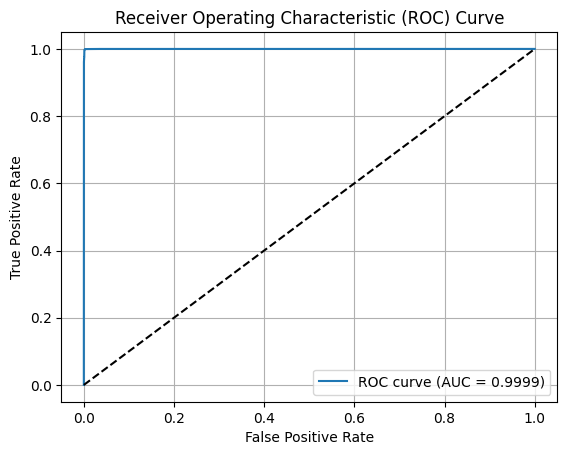

In [10]:
import matplotlib.pyplot as plt
# Get probabilities (for binary classification, we use prob for class 1)
y_scores = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get prob for class 1
        y_scores.extend(probs.cpu().numpy())

# Now compute ROC data
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()